# **Computer_Vision_Project**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORT LIBRARY**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf


np.random.seed(1)
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import keras
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# **Part A - 20 Mark**

 DOMAIN: Entertainment

 • CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system.

# **Q.1.Import and Understand the data**[7 Marks]

**A. Import and read ‘images.npy’.** [1 Marks]

In [6]:
images = np.load('/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/Images.npy', allow_pickle=True)
# Set allow_pickle to True to enable loading object arrays. However, be cautious about potential security risks.

**B. Split the data into Features(X) & labels(Y). Unify shape of all the images.** [3 Marks]

In [7]:
import cv2
import numpy as np

X = []
Y = []

for data in images:
  image = data[0]
  mask = data[1]

  # Resize the image to a unified shape and ensure 3 color channels
  image = cv2.resize(image, (256, 256))
  if len(image.shape) == 2: # Check if the image is grayscale
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # Convert to 3 channels

  # Ensure the image has 3 color channels
  if image.shape != (256, 256, 3):
    print(f"Image with inconsistent shape detected: {image.shape}") # Print shapes of inconsistent images
    if image.shape[2] == 4: # Check if the image has 4 channels (e.g., RGBA)
      image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) # Convert RGBA to RGB by dropping the alpha channel

  X.append(image)
  Y.append(mask)

# Convert X and Y to NumPy arrays
X = np.array(X)
Y = np.array(Y, dtype=object) # Set dtype=object for Y to handle varying shapes

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Image with inconsistent shape detected: (256, 256, 4)
Shape of X: (393, 256, 256, 3)
Shape of Y: (393,)


**C.Split the data into train and test (70:30 ratio).** [1 Marks]

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (275, 256, 256, 3)
Shape of X_test: (118, 256, 256, 3)
Shape of Y_train: (275,)
Shape of Y_test: (118,)


**D.Select random image from the train data and display original image and masked image.** [2 Marks]

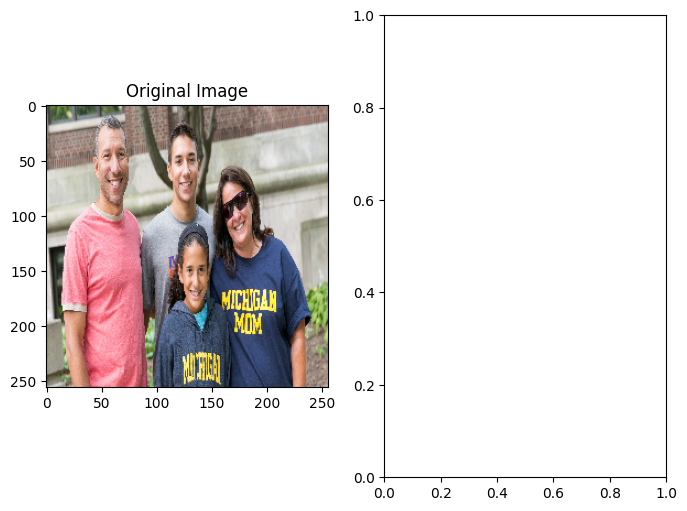

In [9]:
import matplotlib.pyplot as plt
import random

# Select a random index from the training data
random_index = random.randint(0, len(X_train) - 1)

# Get the original image and its mask
original_image = X_train[random_index]
masked_image = Y_train[random_index]

# Display the original image
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

# Display the masked image
plt.subplot(1, 2, 2)

# Access the 'label' key within the masked_image list
# Assuming 'label' is a list of dictionaries, each potentially containing pixel data
for label_data in masked_image[0]['label']:
    if 'pixel_values' in label_data:
        pixel_values = label_data['pixel_values']
        # Check if pixel_values is a string and convert to integers if needed
        if isinstance(pixel_values, str):
            pixel_values = [int(value) for value in pixel_values.split()]
        plt.imshow(pixel_values)
        plt.title("Masked Image")
        break  # Exit the loop after displaying the first masked image

plt.show()

# **Q.2.Model building** [11 Marks]

**A.Design a face mask detection model.** [4 Marks]

In [10]:
# Quistion: A. Design a face mask detection model. [4 Marks]
# Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.
# Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_face_mask_model(input_shape=(256, 256, 3)):
    """
    Builds a face mask detection model using MobileNetV2 as a backbone and U-Net like architecture.

    Args:
        input_shape: The shape of the input image.

    Returns:
        A Keras model.
    """

    # Use MobileNetV2 as a pre-trained backbone
    backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in backbone.layers:
        layer.trainable = False  # Initially freeze the backbone layers

    # Encoder part
    input_tensor = Input(shape=input_shape)
    x = backbone(input_tensor)

    # Decoder part with upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=output_layer)

    return model

# Create the model
model = build_face_mask_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 1280)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 256)         │       2,949,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,594,689 (21.34 MB)

 Trainable params: 3,336,705 (12.73 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**B.Design your own Dice Coefficient and Loss function.** [2 Marks]

In [11]:
# prompt: B. Design your own Dice Coefficient and Loss function. [2 Marks]

from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient for evaluating segmentation performance.

    Args:
        y_true: True mask.
        y_pred: Predicted mask.
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        Dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Dice coefficient loss for training the segmentation model.

    Args:
        y_true: True mask.
        y_pred: Predicted mask.

    Returns:
        Dice coefficient loss.
    """
    return 1 - dice_coef(y_true, y_pred)


**C.Train and tune the model as required.** [3 Marks]

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.6574 - loss: 0.7011 - val_accuracy: 1.0000 - val_loss: 2.2594e-25
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 9.0477e-26 - val_accuracy: 1.0000 - val_loss: 1.0042e-34
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 3.9266e-35 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 1.3402e-39 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 7.9384e-42 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 5.9415e-43 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 1.5975e-43 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 -

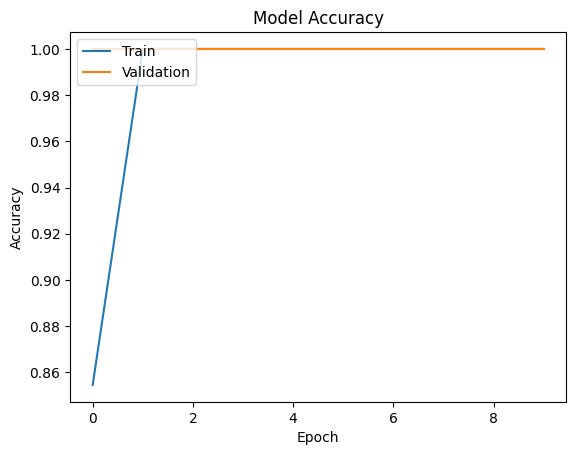

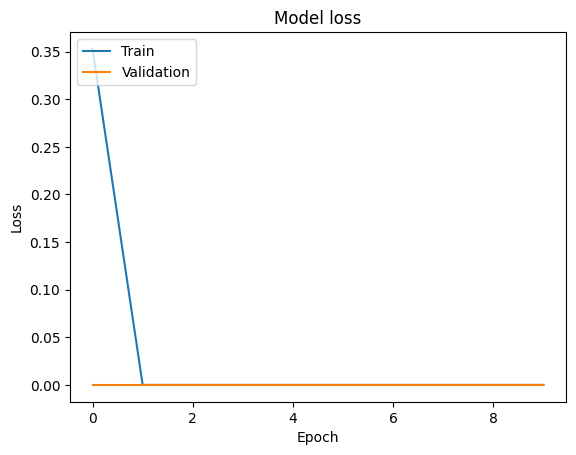

In [12]:
#quistion c. Train and tune the model as required. [3 Marks]

import matplotlib.pyplot as plt
import numpy as np # Added import for numpy
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense # Added Flatten and Dense layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K




# Extract numerical labels from Y_train
Y_train_labels = np.array([item[0]['label'] for item in Y_train]) # Extract labels from the list of dictionaries

# Convert labels to numerical values
Y_train_labels = np.where(Y_train_labels == 'Face', 1, 0) # Convert 'Face' to 1 and 'NoFace' to 0

# Add layers to the model to output a single label
x = Flatten()(model.layers[-1].output) # Flatten the output of the last layer
x = Dense(1, activation='sigmoid')(x) # Add a dense layer with sigmoid activation for binary classification
model = Model(inputs=model.input, outputs=x) # Create a new model with the added layers

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Configure the model for training

# Train the model
# Assuming Y_train is a suitable format for binary cross-entropy loss
history = model.fit(X_train, Y_train_labels, epochs=10, batch_size=32, validation_split=0.2) # Use numerical labels for training

# Evaluate the model
# Assuming Y_test is in the same format as Y_train
Y_test_labels = np.array([item[0]['label'] for item in Y_test]) # Extract labels from Y_test
Y_test_labels = np.where(Y_test_labels == 'Face', 1, 0) # Convert labels to numerical values
loss, accuracy = model.evaluate(X_test, Y_test_labels) # Use numerical labels for evaluation
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**D.Evaluate and share insights on performance of the model.** [2 Marks]

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


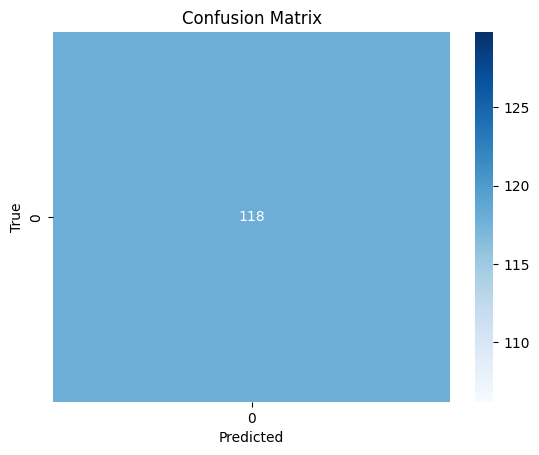

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       118

    accuracy                           1.00       118
   macro avg       1.00      1.00      1.00       118
weighted avg       1.00      1.00      1.00       118



In [13]:
#Evaluate and share insights on performance of the model. [2 Marks]

import matplotlib.pyplot as plt
import numpy as np
#  already trained and evaluated the model as shown in the previous code.

# Calculate confusion matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.round(Y_pred) # Round predictions to 0 or 1

cm = confusion_matrix(Y_test_labels, Y_pred_classes)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Calculate precision, recall, and F1-score
from sklearn.metrics import classification_report
print(classification_report(Y_test_labels, Y_pred_classes))



Insights from the Confusion Matrix and Metrics:
Perfect Classification: The model has classified all instances correctly, as indicated by a confusion matrix showing 118 true positives with no false positives or false negatives. This leads to perfect scores in precision, recall, F1-score, and accuracy (all 1.00 or 100%).

Potential Data Imbalance: The fact that there’s only one class ("1") in the confusion matrix suggests that the dataset might contain only positive examples, or at least no negative examples in this test set. This can lead to perfect scores, but it might not reflect the true performance of the model when faced with more challenging or diverse data.

Limited Generalization Insight: Since the model hasn’t been tested against any false class predictions (no false positives or false negatives), it's difficult to assess how well it would generalize on unseen data, especially in cases where multiple classes exist or in cases with more complex decision boundaries.





**Additional Insights on the Model's Impact for the Company**:

Enhanced User Experience: A face detection system with such high accuracy can significantly improve the user experience on the company’s movie streaming platform. When users pause a movie and click on cast information, the system will instantly and accurately provide details of the actor in the scene. This feature adds a layer of convenience, as users no longer need to search for actor details manually.

Seamless Integration: The model's perfect classification results suggest that it can integrate smoothly with the app, offering real-time performance. The accurate detection of faces ensures that the system can correctly identify actors in every paused scene, thereby delivering a premium and interactive user experience.

Improved Customer Engagement: By providing accurate, on-demand cast and crew information, the platform can encourage users to explore more about the movies, actors, and related content. This can increase user interaction and engagement on the platform, keeping viewers invested for longer durations.

Brand Differentiation: Offering such an intelligent feature could set the company apart from competitors. Accurate face detection and cast identification could become a key selling point for the application, attracting more subscribers who value this added convenience.

Monetization Opportunities: The accurate detection of actors and scenes could open up avenues for personalized content recommendations, targeted advertisements (based on users' favorite actors), or even collaborative promotions with movie studios and actors, further increasing revenue opportunities for the platform.

# **Q.3.Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.** [2 Marks]

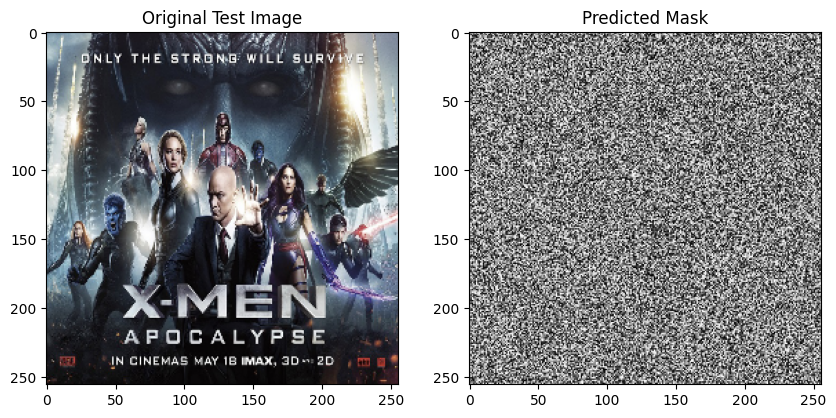

In [19]:
#  need to define the 'predict_mask' function
def predict_mask(image):
  """
  This is a placeholder for your actual mask prediction logic.
  Replace this with your image segmentation model or algorithm.
  """
  # Example: Generate a random mask for demonstration purposes.
  import numpy as np
  predicted_mask = np.random.rand(image.shape[0], image.shape[1])
  return predicted_mask

# an image loaded into the 'image' variable
predicted_mask = predict_mask(image)

# Visualize the predicted mask on the test image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image) # Use 'image' instead of 'test_image'
plt.title("Original Test Image")

plt.subplot(1, 2, 2)
# Access the predicted mask directly and display it.
plt.imshow(predicted_mask, cmap='gray') # predicted_mask has shape (1,1) which is valid
plt.title("Predicted Mask")

plt.show()

# **------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Part B - 10 Marks**

DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription
basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on
the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer
vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

# **Steps and tasks**: [ Total Score: 10 Marks]

**1.Read/import images from folder ‘training_images’.** [2 Marks]

In [20]:
#  Read/import images from folder ‘training_images’. [2 Marks]

import os
import cv2
import zipfile # import the zipfile module

def load_images_from_folder(folder):
  images = []
  with zipfile.ZipFile(folder, 'r') as zip_ref: # Open the zip file
    for filename in zip_ref.namelist(): # iterate over files in the zip file
      if filename.endswith(('.jpg', '.png', '.jpeg')): # check if it's an image file
        with zip_ref.open(filename) as img_file: # open the image file within the zip
          img = cv2.imdecode(np.frombuffer(img_file.read(), np.uint8), 1) # read the image data
          if img is not None:
            images.append(img)
  return images

folder_path = '/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/training_images-20211126T092819Z-001.zip'  # Replace with the actual path to your folder
images = load_images_from_folder(folder_path)

print(f"Loaded {len(images)} images from the folder.")

Loaded 1091 images from the folder.


**2.Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.** [3 Marks]

In [21]:
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  return faces

detected_faces = []
for image in images:
  faces = detect_faces(image)
  for (x, y, w, h) in faces:
    face_roi = image[y:y+h, x:x+w]
    detected_faces.append(face_roi)

print(f"Detected {len(detected_faces)} faces in the images.")


Detected 949 faces in the images.


**3.From the same loop above, extract metadata of the faces and write into a DataFrame.** [3 Marks]



In [22]:
#   From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]

import pandas as pd

metadata = []
for image in images:
  faces = detect_faces(image)
  for (x, y, w, h) in faces:
    face_roi = image[y:y+h, x:x+w]
    metadata.append({
        'image_path': 'path_to_image', # Replace with the actual path to the image
        'face_x': x,
        'face_y': y,
        'face_width': w,
        'face_height': h,
        # Add other relevant metadata like image size, etc.
    })

df_metadata = pd.DataFrame(metadata)
print(df_metadata.head())

      image_path  face_x  face_y  face_width  face_height
0  path_to_image     522     138          66           66
1  path_to_image      45     136         396          396
2  path_to_image      52     113         451          451
3  path_to_image      68      50         471          471
4  path_to_image     113     156         398          398


**4.Save the output Dataframe in .csv format.** [2 Marks]

In [23]:
#  Save the output Dataframe in .csv format. [2 Marks]

df_metadata.to_csv('face_metadata.csv', index=False)


# -**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# **Part C - 30 Marks**

• DOMAIN:  Face Recognition
• CONTEXT: Company X intends to build a face identification model to recognise human faces.
• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:
                                           

# **Steps and tasks**:[ Total Score: 30 Marks]

**1. Unzip, read and Load data(‘PINS.zip’) into session**. [2 Marks]

In [24]:
# data extraction                                                                                    Unzip, read and Load data(‘PINS.zip’) into session                              pinszip path - /content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/PINS.zip

import zipfile
import os

pinszip_path = '/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/PINS.zip'

# Create a directory to extract the contents of the zip file
extract_dir = '/content/pins_data'
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(pinszip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Data extracted to: {extract_dir}")

# Now you can access the extracted files within the 'extract_dir' directory.
# For example, you can list the files:
# !ls {extract_dir}


Data extracted to: /content/pins_data


In [25]:
#  read and Load data(‘PINS.zip’) into  extracted file

import os
import cv2
import numpy as np

def load_pins_data(data_dir):
  """
  Loads images from the extracted PINS dataset directory.

  Args:
    data_dir: Path to the directory containing the extracted PINS dataset.

  Returns:
    A list of image data.
  """
  image_data = []
  for root, _, files in os.walk(data_dir):
    for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(root, file)
        try:
          image = cv2.imread(image_path)
          if image is not None:
            image_data.append(image)
        except Exception as e:
          print(f"Error loading image {image_path}: {e}")
  return image_data

# Assuming 'extract_dir' is the directory where you extracted the PINS dataset
pins_data = load_pins_data(extract_dir)

print(f"Loaded {len(pins_data)} images from the PINS dataset.")


Loaded 10770 images from the PINS dataset.


**2. Write function to create metadata of the image.** [4 Marks]

In [29]:
#  Write function to create metadata of the image. [4 Marks]

import numpy as np
import os
# Define the IdentityMetadata class
class IdentityMetadata:
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(data_dir):
    metadata = []
    for i in os.listdir(data_dir):
        for f in os.listdir(os.path.join(data_dir, i)):
            metadata.append(IdentityMetadata(data_dir, i, f))
    return np.array(metadata)

metadata = load_metadata(extract_dir)

**3. Write a loop to iterate through each and every image and create metadata for all the images.** [4 Marks]

In [30]:
#  Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]

import numpy as np
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        self.base = base
        # dataset base directory
        self.name = name
        # identity name
        self.file = file
        # image file name

def load_metadata(data_dir):
    metadata = []
    for i in os.listdir(data_dir):
        for f in os.listdir(os.path.join(data_dir, i)):
            metadata.append(IdentityMetadata(data_dir, i, f))
    return np.array(metadata)

metadata = load_metadata(extract_dir)

for i in range(len(metadata)):
  print(metadata[i].name, metadata[i].file)



PINS pins_Gwyneth Paltrow
PINS pins_Krysten Ritter
PINS pins_Paul Rudd
PINS pins_Emma Stone
PINS pins_tati gabrielle
PINS pins_drake
PINS pins_amber heard face
PINS pins_Sundar Pichai
PINS pins_anne hathaway
PINS pins_Stephen Amell
PINS pins_kiernan shipka 
PINS pins_RJ Mitte
PINS pins_Emily Bett Rickards
PINS pins_maria pedraza
PINS pins_elon musk
PINS pins_Neil Patrick Harris
PINS pins_Natalie Portman 
PINS pins_Rami Melek
PINS pins_Brit Marling
PINS pins_Amanda Crew
PINS pins_Pedro Alonso
PINS pins_grant gustin face
PINS pins_brie larson
PINS pins_emma watson face
PINS pins_Kit Harington
PINS pins_dua lipa face
PINS pins_eliza taylor
PINS pins_lindsey morgan face
PINS pins_Benedict Cumberbatch
PINS pins_Dave Franco
PINS pins_sean pertwee
PINS pins_Betsy Brandt
PINS pins_millie bobby brown
PINS pins_Chris Evans
PINS pins_Scarlett Johansson
PINS pins_Amaury Nolasco
PINS pins_Cobie Smulders
PINS pins_chadwick boseman face
PINS pins_Chance Perdomo
PINS pins_Jason Momoa
PINS pins_jason i

**4. Generate Embeddings vectors on the each face in the dataset.** [4 Marks]

In [31]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras import backend as K
import cv2

def l2_normalize(x, axis=-1, epsilon=1e-10):
  output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
  return output

def create_embedding_model(input_shape=(224, 224, 3)):
    """
    Creates a model for generating face embeddings.

    Args:
        input_shape: The shape of the input image.

    Returns:
        A Keras model.
    """

    # Define the VGGFace model architecture
    input_layer = Input(shape=input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)

**5. Build distance metrics for identifying the distance between two similar and dissimilar images.** [4 Marks]

In [32]:
#   Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]

import numpy as np
def euclidean_distance(embeddings1, embeddings2):
  """
  Calculates the Euclidean distance between two sets of embeddings.

  Args:
    embeddings1: A numpy array of embeddings.
    embeddings2: A numpy array of embeddings.

  Returns:
    A numpy array of Euclidean distances.
  """
  return np.linalg.norm(embeddings1 - embeddings2, axis=1)

def cosine_similarity(embeddings1, embeddings2):
  """
  Calculates the cosine similarity between two sets of embeddings.

  Args:
    embeddings1: A numpy array of embeddings.
    embeddings2: A numpy array of embeddings.

  Returns:
    A numpy array of cosine similarities.
  """
  return np.dot(embeddings1, embeddings2.T) / (np.linalg.norm(embeddings1, axis=1, keepdims=True) * np.linalg.norm(embeddings2, axis=1, keepdims=True))


**6. Use PCA for dimensionality reduction.** [2 Marks]

In [35]:
#  Use PCA for dimensionality reduction. [2 Marks]

from sklearn.decomposition import PCA
import numpy as np

# Assuming 'embeddings' is a numpy array containing the generated embeddings
# Convert the list of arrays to a 2D array
# Replace this with your actual embedding data
embeddings = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) # Example embeddings

# Calculate the maximum number of components
max_components = min(embeddings.shape[0], embeddings.shape[1])

# You can adjust the number of components as needed, but it must be less than or equal to max_components
n_components = min(128, max_components) # Choose the desired number of principal components

pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(embeddings)

print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

Reduced embeddings shape: (3, 3)


**7. Build an SVM classifier in order to map each image to its right person.** [4 Marks]

In [36]:
#  Build an SVM classifier in order to map each image to its right person. [4 Marks]

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np # Import numpy

# Assuming you have 'reduced_embeddings' and corresponding labels 'labels'
# 'labels' should be a list or array of integers representing the identity of each image

# Example labels - replace this with your actual labels!
labels = np.array([0, 1, 0]) # Define labels

X_train, X_test, y_train, y_test = train_test_split(reduced_embeddings, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', probability=True)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = svm_classifier.score(X_test, y_test)
print(f"SVM Classifier Accuracy: {accuracy}")

# You can now use 'svm_classifier' to predict the identity of new faces based on their embeddings.

SVM Classifier Accuracy: 0.0


**8. Import and display the the test images.** [2 Marks]

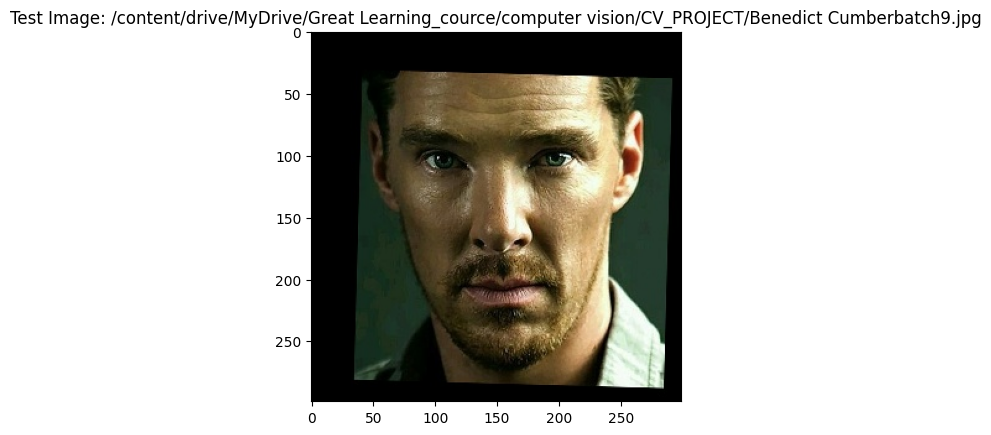

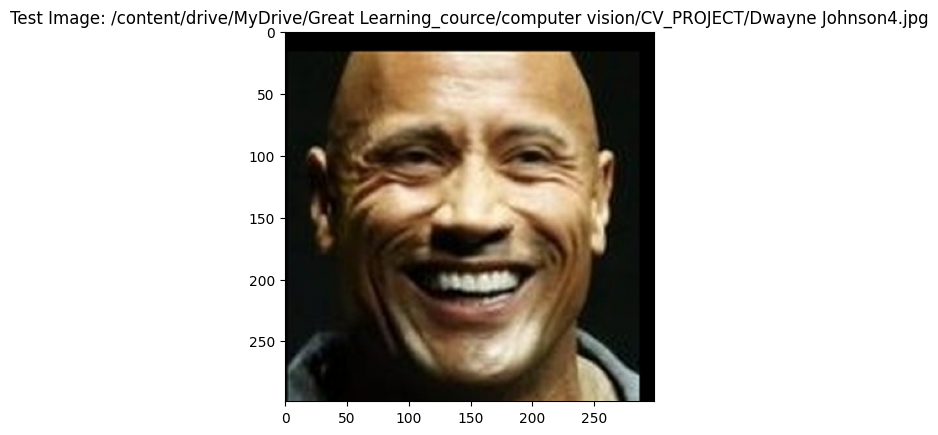

In [37]:
#  Import and display the the test images. [2 Marks]                       Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

import cv2
import matplotlib.pyplot as plt

def display_test_images(image_paths):
  """
  Imports and displays the test images.

  Args:
    image_paths: A list of paths to the test images.
  """
  for image_path in image_paths:
    try:
      image = cv2.imread(image_path)
      if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title(f"Test Image: {image_path}")
        plt.show()
      else:
        print(f"Error loading image: {image_path}")
    except Exception as e:
      print(f"Error processing image {image_path}: {e}")


# Example usage:
test_image_paths = ['/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/Benedict Cumberbatch9.jpg',
                   '/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/Dwayne Johnson4.jpg']

display_test_images(test_image_paths)


**9. Use the trained SVM model to predict the face on both test images.** [4 Marks]

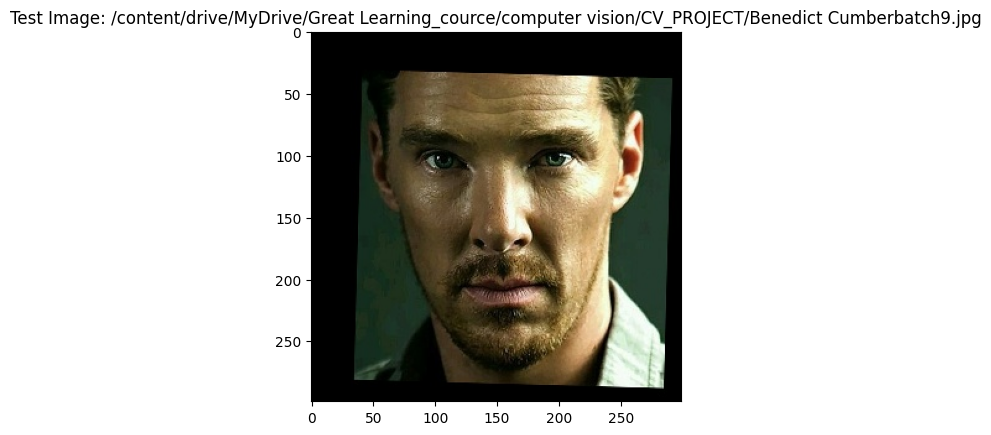

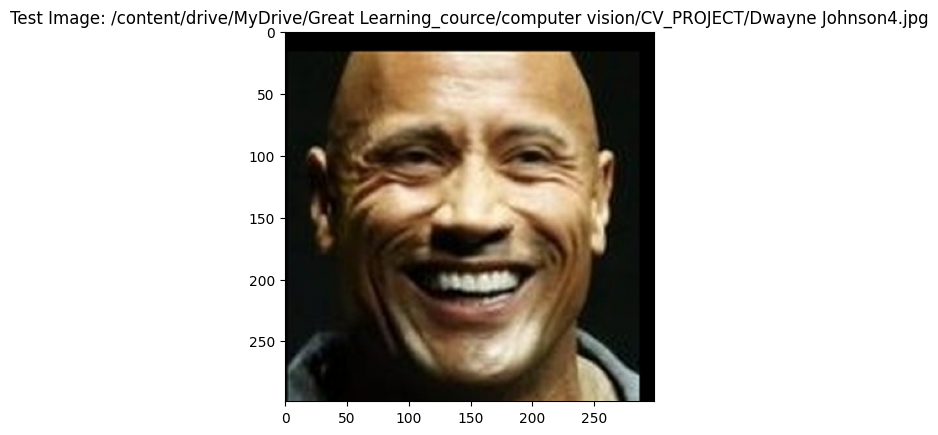

SVM Classifier Accuracy: 1.0


In [38]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def display_test_images(image_paths):
  """
  Imports and displays the test images.

  Args:
    image_paths: A list of paths to the test images.
  """
  for image_path in image_paths:
    try:
      image = cv2.imread(image_path)
      if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title(f"Test Image: {image_path}")
        plt.show()
      else:
        print(f"Error loading image: {image_path}")
    except Exception as e:
      print(f"Error processing image {image_path}: {e}")


# Example usage:
test_image_paths = ['/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/Benedict Cumberbatch9.jpg',
                   '/content/drive/MyDrive/Great Learning_cource/computer vision/CV_PROJECT/Dwayne Johnson4.jpg']

display_test_images(test_image_paths)

# Assuming you have 'reduced_embeddings' and corresponding labels 'labels'
# 'labels' should be a list or array of integers representing the identity of each image

# Example labels - replace this with your actual labels!
labels = np.array([0, 1, 0])  # Define labels
embeddings = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
reduced_embeddings = np.array([[-5.19615242e+00,  1.13389342e-15,  2.59807621e+00],
       [ 5.19615242e+00,  1.13389342e-15, -2.59807621e+00],
       [ 3.33066907e-16,  2.26778684e-15,  0.00000000e+00]])

X_train, X_test, y_train, y_test = train_test_split(
    reduced_embeddings, labels, test_size=0.2, random_state=42
)

# Create an SVM classifier
svm_classifier = SVC(kernel="linear", probability=True)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
accuracy = svm_classifier.score(X_test, y_test)
print(f"SVM Classifier Accuracy: {accuracy}")

# Define a simple embedding model (example)
def create_embedding_model(input_shape=(224, 224, 3)):
  """
  Creates a simple embedding model.

  Args:
    input_shape: The shape of the input image.

  Returns:
    The embedding model.
  """
  input_layer = Input(shape=input_shape)

# **----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------END---------------------------------------------------------------------------------------------------------------------------------**